In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from statistics import mean

In [2]:
PATH = "../Data/Images/"

In [3]:
print(f'{PATH}G1.JPG')

../Data/Images/G1.JPG


In [4]:
img1 = cv.imread(f'{PATH}G1.JPG', cv.COLOR_BGR2GRAY)
img2 = cv.imread(f'{PATH}G2.JPG', cv.COLOR_BGR2GRAY)
img19 = cv.imread(f'{PATH}G19.JPG', cv.COLOR_BGR2GRAY)

# plt.imshow(img1)

# # Initiate ORB detector
# orb = cv.ORB_create()
# # find the keypoints with ORB
# kp1 = orb.detect(img1,None)
# kp2 = orb.detect(img2,None)
# # print(kp1)
# # compute the descriptors with ORB
# kp1, des1 = orb.compute(img1, kp1)
# kp2, des2 = orb.compute(img2, kp2)
# # draw only keypoints location,not size and orientation
# imgD1 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
# imgD2 = cv.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
# plt.figure(figsize = (20,20))
# plt.imshow(imgD1)
# plt.show()

# #Homography calculation 
# pts1 = cv.KeyPoint_convert(kp1)
# pts2 = cv.KeyPoint_convert(kp2)
# h, status = cv.findHomography(pts1, pts2)

# print(h)

In [5]:
def findKeyLocationsColorBis(image_2darray):
    defectColours_list = [[670, 800], [1435, 83]]
    defectCentre_list = []
    
    for defect_1darray in defectColours_list:
        colorMask_2darray = np.all(abs(image_2darray - image_2darray[defect_1darray[0], defect_1darray[1]])< 2, axis=2)
        pointsDefect_2darray = np.asarray(np.where(colorMask_2darray == True)).T
        positionMask_1darray = (abs(pointsDefect_2darray[:, 0]-defect_1darray[0]) < 300) & (abs(pointsDefect_2darray[:, 1]-defect_1darray[1]) < 300)
        finalPointsDefect_2darray = np.squeeze(pointsDefect_2darray[np.asarray(np.where(positionMask_1darray == True))])
        
        coordinatesCentre_1darray = np.round(np.mean(finalPointsDefect_2darray, axis=0))
        
        defectCentre_list.append(coordinatesCentre_1darray)
        
    return defectCentre_list
        

In [5]:
def findKeyLocationPosition(image_2darray, currKp_2darray, xMin, xMax, yMin, yMax):
    currKp_2darray[xMin:xMax, yMin:yMax] = 1
    return currKp_2darray

In [6]:
def findKeyLocationsColor(image_2darray, currKp_2darray, color_array):
    colorMask_2darray = np.mean(np.absolute(image_2darray - color_array), axis=2)< 25
    pointsDefect_2darray = np.asarray(np.where(colorMask_2darray == True)).T
#     positionMask_1darray = (abs(pointsDefect_2darray[:, 0]-defect_1darray[0]) < 300) & (abs(pointsDefect_2darray[:, 1]-defect_1darray[1]) < 300)
#     finalPointsDefect_2darray = np.squeeze(pointsDefect_2darray[np.asarray(np.where(positionMask_1darray == True))])
    currKp_2darray = np.logical_and(currKp_2darray, colorMask_2darray)
    return currKp_2darray

In [7]:
def findKeyLocationsGrad(image_2darray, currKp_2darray, tolerance=10, color=None):
    highGradientMask = np.zeros(currKp_2darray.shape)
    if(color=='red'):
        GradientAbs = np.absolute(np.gradient(image_2darray[:,:,0]))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((gradientArrayY_list>tolerance), (gradientArrayX_list>tolerance))
    elif(color=='green'):
        GradientAbs = np.absolute(np.gradient(image_2darray[:,:,1]))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((gradientArrayY_list>tolerance), (gradientArrayX_list>tolerance))
    elif(color=='blue'):
        GradientAbs = np.absolute(np.gradient(image_2darray[:,:,2]))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((gradientArrayY_list>tolerance), (gradientArrayX_list>tolerance))
    elif(color=='max'):
        GradientAbs = np.absolute(np.gradient(image_2darray))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((np.amax(gradientArrayY_list, axis=2)>tolerance), (np.amax(gradientArrayX_list, axis=2)>tolerance))
    elif(color=='min'):
        GradientAbs = np.absolute(np.gradient(image_2darray))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((np.amin(gradientArrayY_list, axis=2)>tolerance), (np.amin(gradientArrayX_list, axis=2)>tolerance))
    else:
        GradientAbs = np.absolute(np.gradient(image_2darray, edge_order=2))
        gradientArrayY_list, gradientArrayX_list = GradientAbs[0], GradientAbs[1]
        highGradientMask = np.bitwise_or((np.mean(gradientArrayY_list, axis=2)>tolerance), (np.mean(gradientArrayX_list, axis=2)>tolerance))

    updatedKp_2darray = np.logical_and(currKp_2darray, highGradientMask)
    return updatedKp_2darray

In [8]:
def plotKeypoints(image, keypoints_2darray):
    iterable_new = []
    keypoints = np.asarray(np.where(keypoints_2darray == True)).T
    for idx, val in enumerate(keypoints):

        iterable_line = [np.uint32(keypoints[idx][1]).item(), np.uint32(keypoints[idx][0]).item()]
        iterable_new.append(iterable_line)
        
    area1 = cv.KeyPoint_convert(iterable_new)
    imagePlot = cv.drawKeypoints(image, area1, None, color=(255,0,0), flags=0)
    
    plt.figure(figsize = (20,20))
    plt.imshow(imagePlot)
    plt.show()
    return

In [9]:
initialKp = np.zeros(img1.shape)[:,:,0]
positionKp = findKeyLocationPosition(img1, initialKp, 2875, 3700, 800, 2600)
colourKp = findKeyLocationsColor(img1, positionKp, color_array=[163,182,189])
gradKp = findKeyLocationsGrad(img1, colourKp, color='min')

initialKp19 = np.zeros(img19.shape)[:,:,0]
positionKp19 = findKeyLocationPosition(img19, initialKp19, 2875, 3700, 800, 2600)
colourKp19 = findKeyLocationsColor(img19, positionKp19, color_array=[163,182,189])
gradKp19 = findKeyLocationsGrad(img19, colourKp19, color='min')

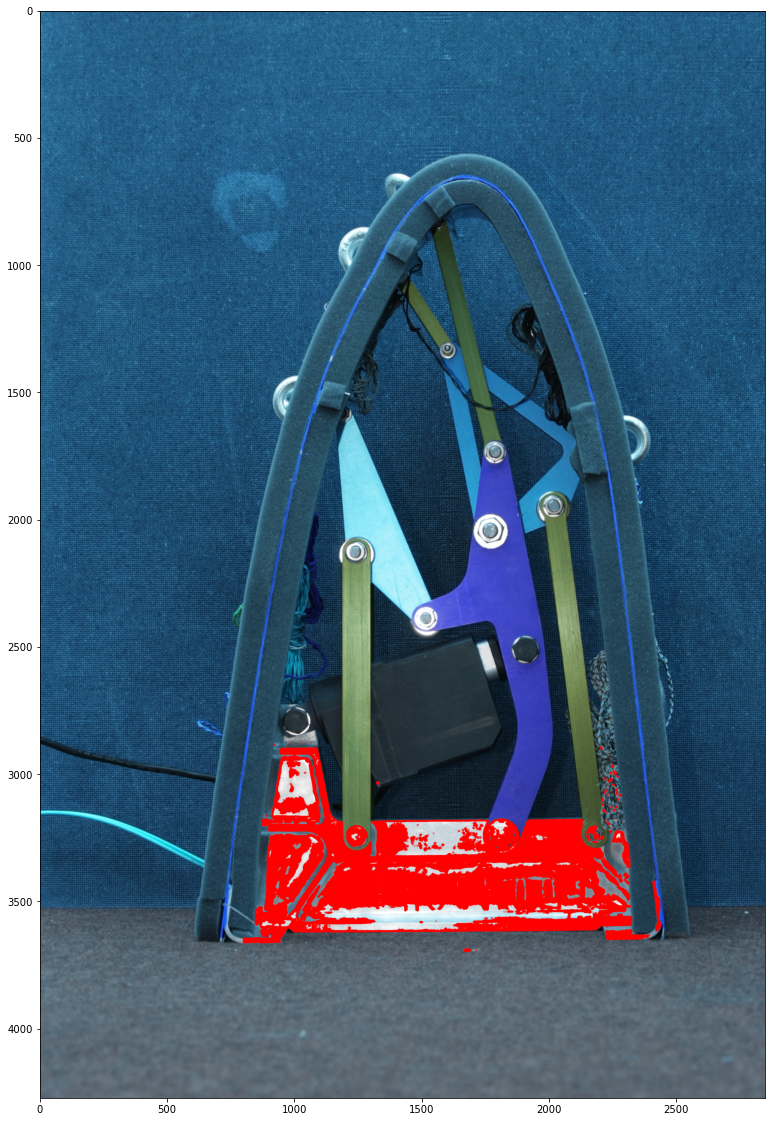

In [10]:
plotKeypoints(img1, colourKp)

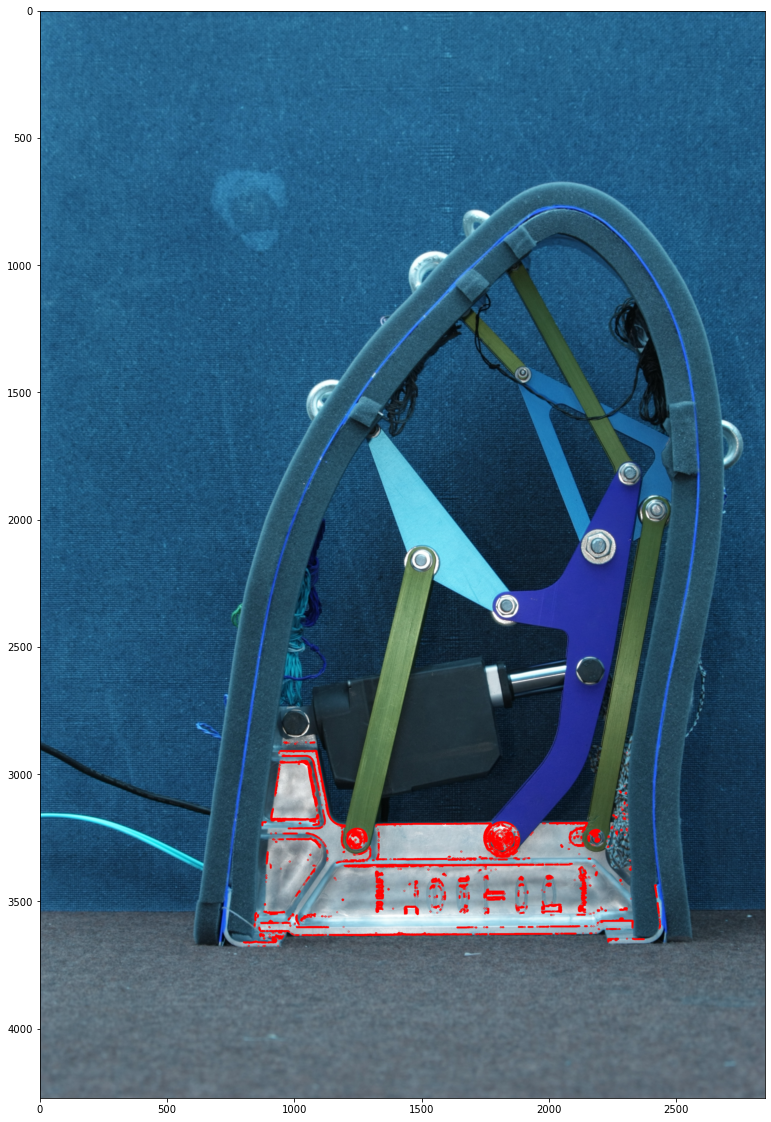

In [55]:
plotKeypoints(img19, gradKp19)

In [47]:
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=10)
# print(img1[0,:,0])
print(img1.shape)

(4272, 2848, 3)


In [6]:
print(findKeyLocations(img1))
print(findKeyLocations(img2))
print(findKeyLocations(img19))

[array([754., 801.]), array([1471.,  108.])]
[array([751., 806.]), array([1334.,  176.])]
[array([778., 824.]), array([1394.,  202.])]


[156.  10.]


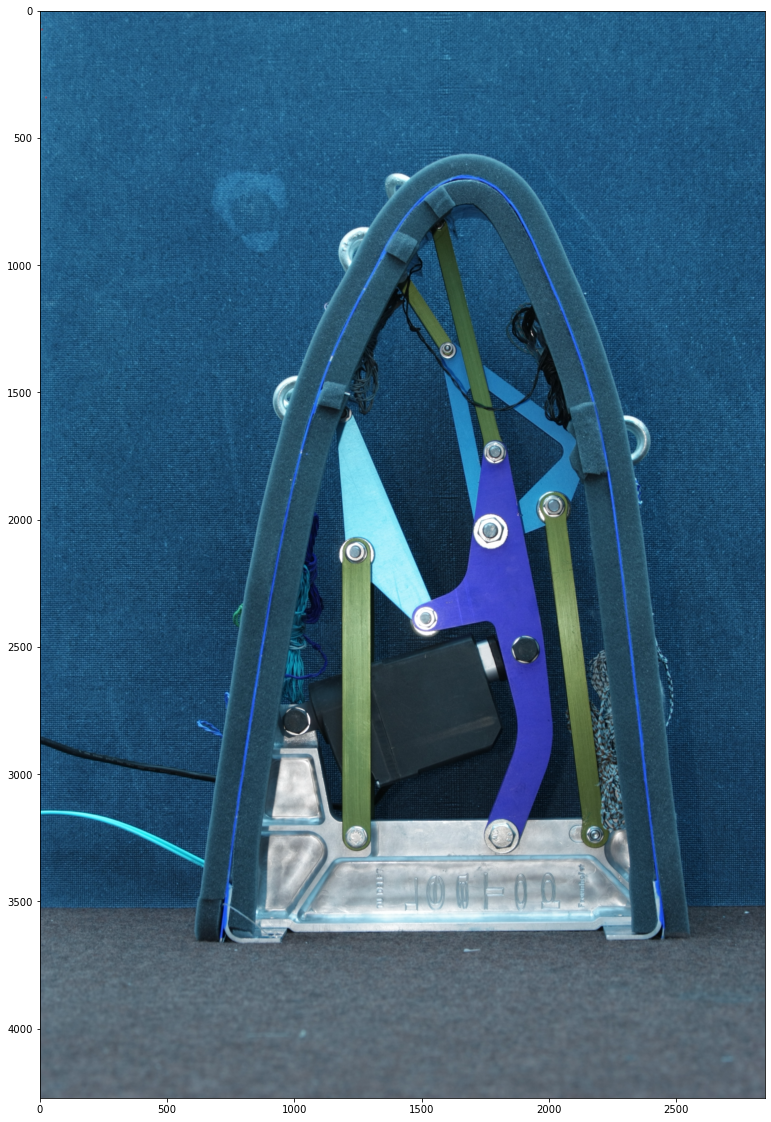

In [181]:
#Defining colours
defect1colour = img1[83, 1435] #Circular patch 1
mask1 = np.all(abs(img1 - defect1colour)< 3, axis=2)
pts = np.asarray(np.where(mask1 == True)).T
posMask1 = (abs(pts[:, 0]-defect1colour[0]) < 300) & (abs(pts[:, 1]-defect1colour[1]) < 300)
pts1 = np.squeeze(pts[np.asarray(np.where(posMask1 == True))])

iterable_new = []

for idx, val in enumerate(pts1):

    iterable_line = [np.uint32(pts1[idx][1]).item(), np.uint32(pts1[idx][0]).item()]
    iterable_new.append(iterable_line)
    
centre1 = np.round(np.mean(pts1, axis=0))

print(centre1)

testKp = cv.KeyPoint_convert([[1435, 83]])
area1 = cv.KeyPoint_convert(iterable_new)
centre1 = cv.KeyPoint_convert([[centre1[1].item(), centre1[0].item()]])

testImg = cv.drawKeypoints(img1, testKp, None, color=(255,0,0), flags=0)
imgD1 = cv.drawKeypoints(img1, area1, None, color=(255,0,0), flags=0)
centreD1 = cv.drawKeypoints(img1, centre1, None, color=(0,255,0), flags=0)
plt.figure(figsize = (20,20))
plt.imshow(imgD1)
plt.show()
# plt.figure(figsize = (20,20))
# plt.imshow(centreD1)
# plt.show()